In [1]:
from optparse import OptionParser
import json
import os
import pickle
import random
import re
import pandas as pd
import pysam
# import h5py
import numpy as np

import tensorflow as tf
from basenji import seqnn, stream

from akita_utils.seq_gens import unshuffled_insertion_gen
from akita_utils.h5_utils import (initialize_stat_output_h5, write_stat_metrics_to_h5)

2024-04-03 14:05:55.818573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 14:05:55.818627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 14:05:55.819510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 14:05:55.825252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 14:05:56.868883: W tensorflow/compiler/tf2

In [2]:
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa"
out_dir = "./OUT"
rc = False
stats = "SCD"
shifts = "0"
batch_size = 4

In [3]:
params_file = "/project/fudenber_735/tensorflow_models/akita/v2/models/f0c0/train/params.json"
model_file = "/project/fudenber_735/tensorflow_models/akita/v2/models/f0c0/train/model1_best.h5"

In [4]:
shuffled_seqs_tsv = "./small_test.tsv"

In [5]:
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

head_index = int(model_file.split("model")[-1][0])
model_index = int(model_file.split("c0")[0][-1])

random.seed(44)

In [6]:
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

In [7]:
# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

In [8]:
seq_coords_df = pd.read_csv(shuffled_seqs_tsv, sep="\t")

In [9]:
num_experiments = len(seq_coords_df)*2

In [10]:
# initialize output
stats_out = initialize_stat_output_h5(out_dir, model_file, stats, seq_coords_df)

In [11]:
# open genome FASTA
genome_open = pysam.Fastafile(
    genome_fasta
)  # needs to be closed at some point

In [12]:
ctcf_site_coordinates = ("chr4", 87368268, 87368249, "+")

In [14]:
from akita_utils.dna_utils import (hot1_rc, dna_1hot, permute_seq_k, dna_rc)

In [15]:
from akita_utils.seq_gens import _insert_casette

In [20]:
def shuffled_insertion_gen(seq_coords_df, genome_open, ctcf_site_coordinates, flank_bp=30, orientation=">"):
    
    ctcf_chrom, ctcf_start, ctcf_end, ctcf_strand = ctcf_site_coordinates

    seq_1hot_insertion = dna_1hot(
            genome_open.fetch(
                ctcf_chrom, ctcf_start - flank_bp, ctcf_end + flank_bp
            ).upper()
        )

    if ctcf_strand == "-":
        seq_1hot_insertion = hot1_rc(seq_1hot_insertion)
    
    for s in seq_coords_df.itertuples():

        sequences_to_yield = []

        # getting genomic sequence
        chrom, start, end = s.chrom, s.start, s.end
        seq_dna = genome_open.fetch(chrom, int(start), int(end))
        wt_seq_1hot = dna_1hot(seq_dna)
        
        mutation_method = s.mutation_method

        if mutation_method == "permute_whole_seq":
            permuted_alt_seq_1hot = permute_seq_k(
                wt_seq_1hot, k=s.shuffle_parameter
            )
            sequences_to_yield.append(permuted_alt_seq_1hot)
        else:
            raise NotImplementedError(
                "Other background generation methods have not been included."
            )
        
        inserted_seq_1hot = _insert_casette(permuted_alt_seq_1hot, seq_1hot_insertion, 0, orientation)
        sequences_to_yield.append(inserted_seq_1hot)

        for seq in sequences_to_yield:
            yield seq

In [21]:
preds_stream = stream.PredStreamGen(
    seqnn_model,
    shuffled_insertion_gen(seq_coords_df, genome_open, ctcf_site_coordinates),
    batch_size,
)

In [22]:
from akita_utils.analysis_utils import plot_map
from akita_utils.utils import ut_dense
from akita_utils.stats_utils import calculate_SCD

5/5 [==============================] - 15s 3s/step
ref


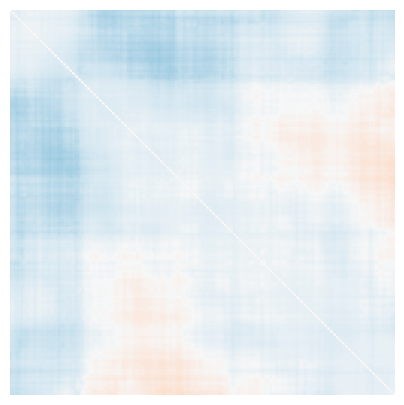

alt


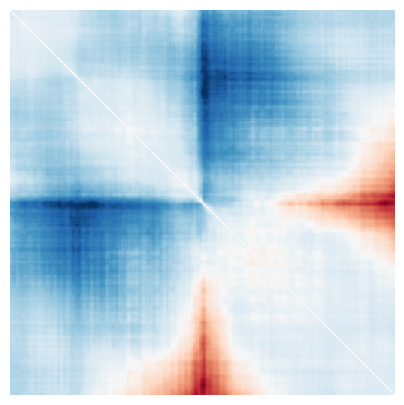

alt-ref


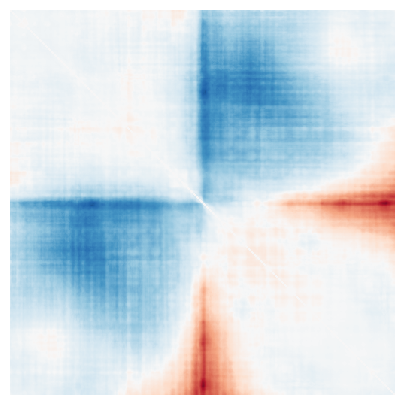

SCD, ref
[30.738344 33.239414 46.28697  51.493084 44.550385 41.239628]
SCD, alt
[78.35959  94.6639   82.034164 81.37434  84.53119  69.237335]
SCD, alt with ref
[60.278103 78.512596 64.33166  61.654186 64.8913   51.29248 ]
ref


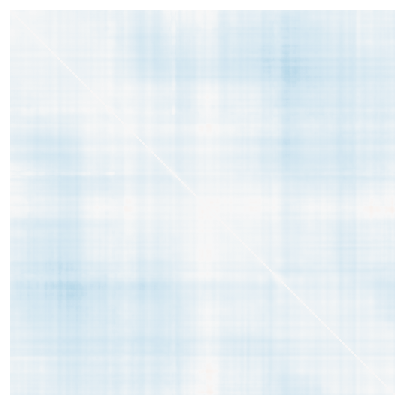

alt


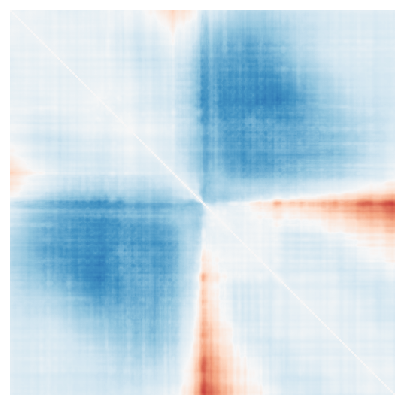

alt-ref


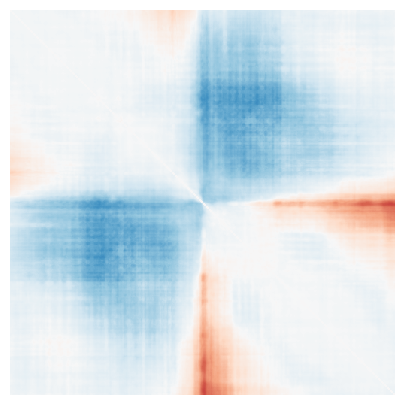

SCD, ref
[22.659603 22.088854 50.85858  49.48044  43.17494  43.10718 ]
SCD, alt
[63.62703  75.53702  74.815346 72.569984 74.922195 62.896408]
SCD, alt with ref
[48.28863  62.48788  50.194798 48.048927 52.598686 40.55853 ]
ref


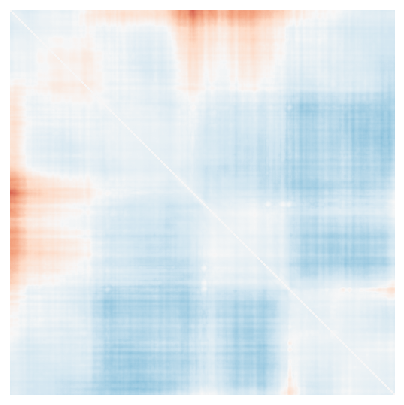

alt


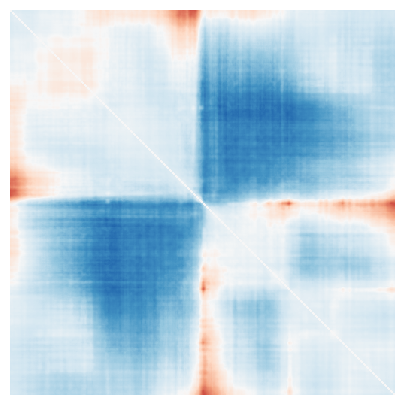

alt-ref


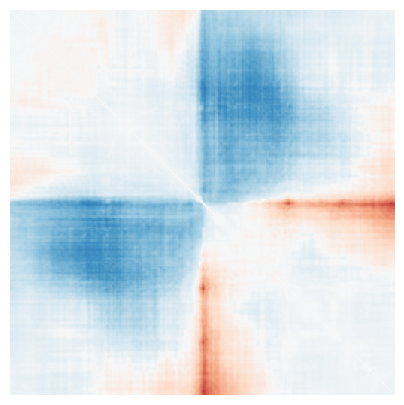

SCD, ref
[38.243793 44.48626  35.399284 36.361225 39.211735 34.7946  ]
SCD, alt
[71.87996  89.31467  91.61818  87.81752  87.55748  70.587265]
SCD, alt with ref
[53.01312  68.06033  75.92657  72.31241  69.61733  55.673992]
ref


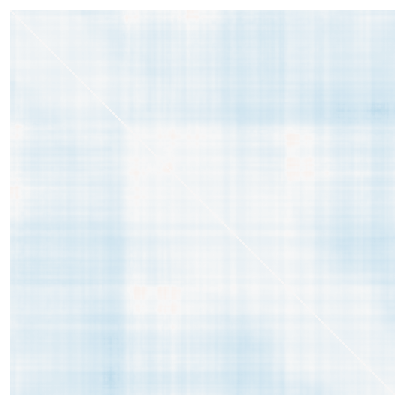

alt


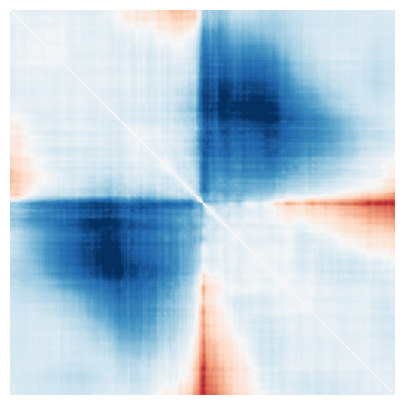

alt-ref


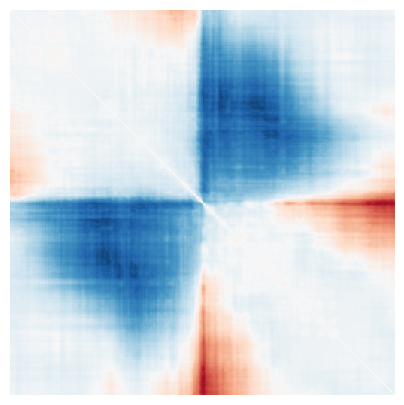

SCD, ref
[20.964737 20.274601 43.99745  44.061317 37.98316  38.17888 ]
SCD, alt
[ 86.91224  105.908394 131.85507  129.27351  120.84281  101.29067 ]
SCD, alt with ref
[ 75.74176   97.37919  113.992615 110.78825  104.52917   85.10397 ]
ref


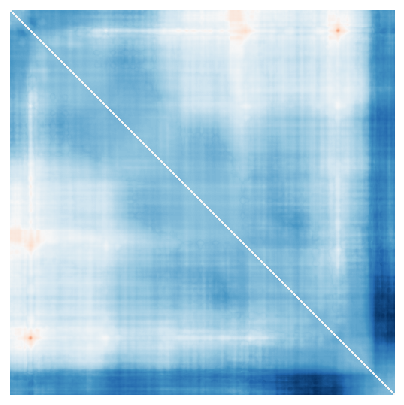

alt


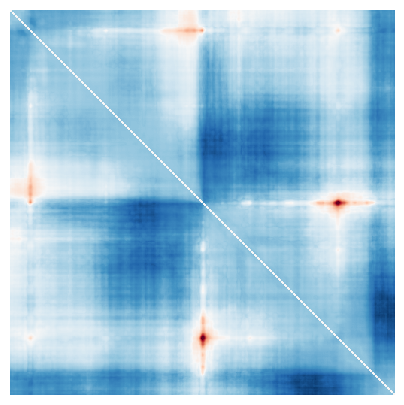

alt-ref


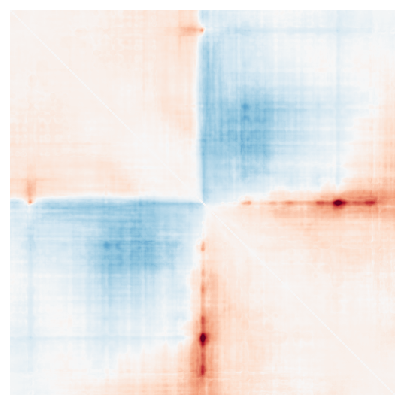

SCD, ref
[ 89.3399  102.49294  77.23228  70.88542  82.20565  65.89602]
SCD, alt
[ 92.83152  113.861046  89.06865   80.905304  94.035385  73.73943 ]
SCD, alt with ref
[36.264652 50.56206  53.691105 48.611614 51.57421  39.744896]
ref


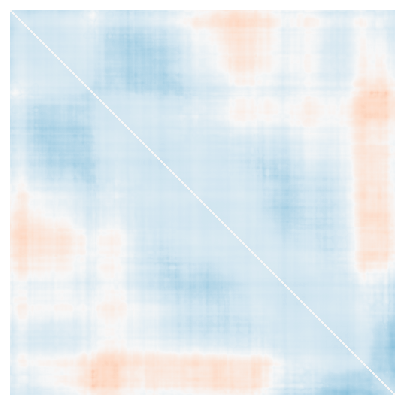

alt


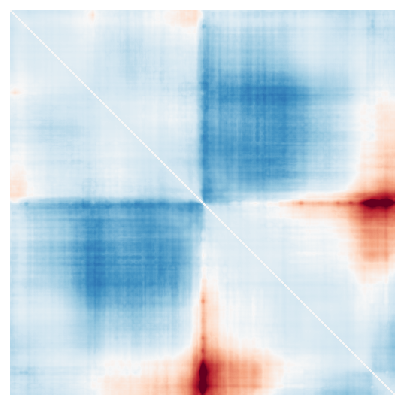

alt-ref


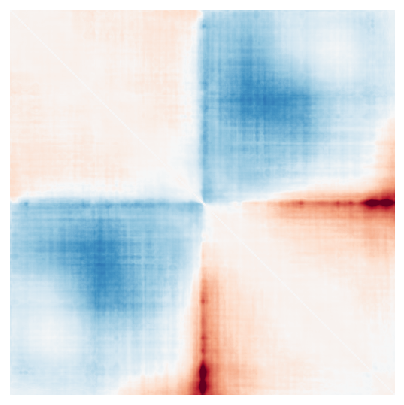

SCD, ref
[34.074234 40.301567 45.363304 47.319195 41.7243   38.924587]
SCD, alt
[66.77558  88.68787  84.7662   80.41885  82.74827  66.674446]
SCD, alt with ref
[56.43244 75.19254 72.62643 67.13478 70.78129 56.06283]
ref


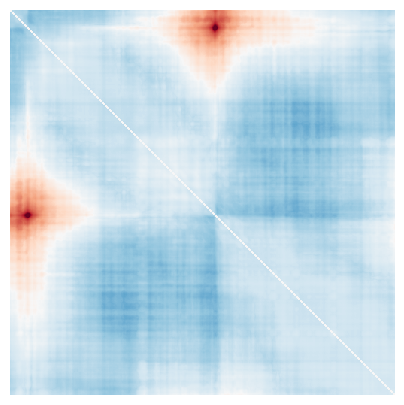

alt


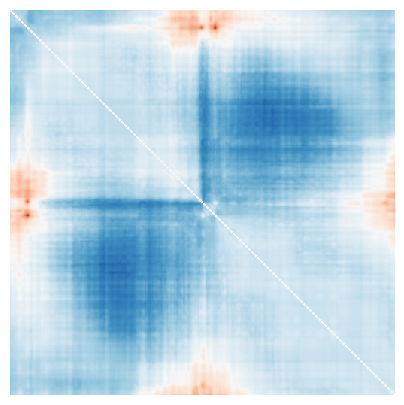

alt-ref


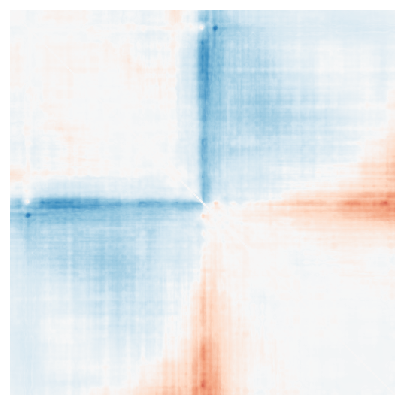

SCD, ref
[58.475666 58.415623 47.174244 45.941654 52.10347  45.08227 ]
SCD, alt
[72.541275 77.60004  67.695946 62.888138 69.47809  56.513145]
SCD, alt with ref
[35.346474 43.475178 38.87878  35.838924 38.483303 30.763445]
ref


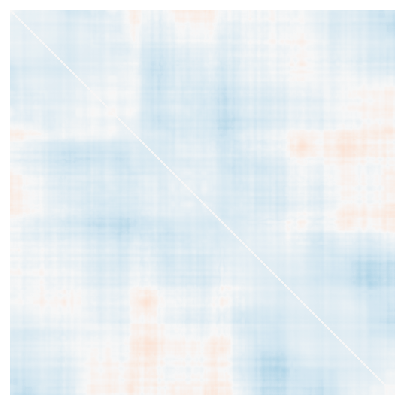

alt


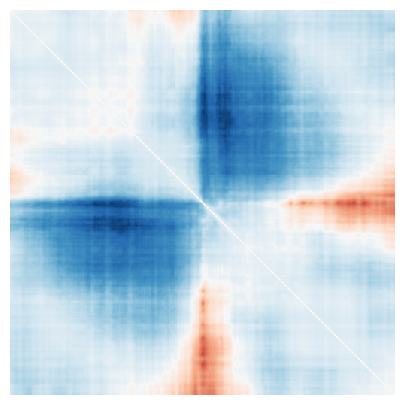

alt-ref


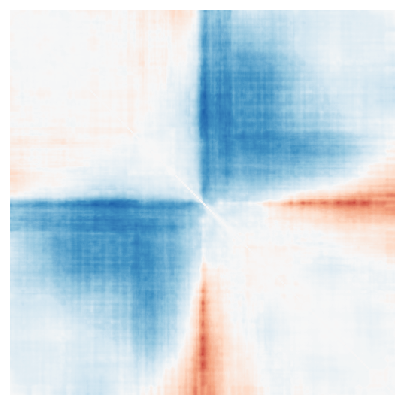

SCD, ref
[23.918882 24.474257 39.783695 43.836987 36.10302  34.3827  ]
SCD, alt
[75.28156  91.201744 90.980385 88.79058  88.80954  72.57418 ]
SCD, alt with ref
[60.993156 76.29266  71.034    67.99517  68.92924  54.927124]
ref


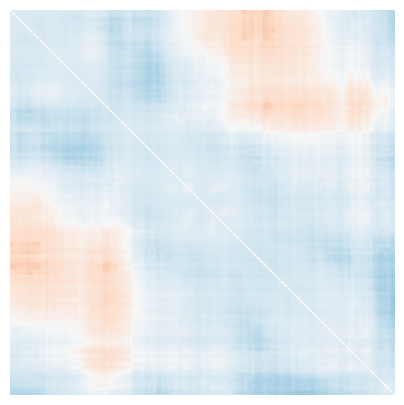

alt


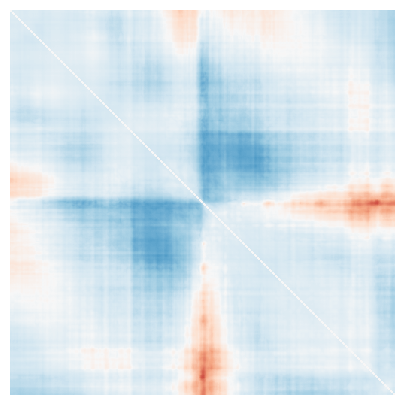

alt-ref


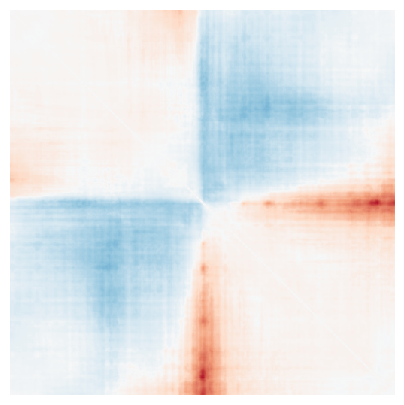

SCD, ref
[34.187584 36.044228 37.75396  39.565674 36.785038 32.539494]
SCD, alt
[44.030754 56.131657 49.088875 48.118294 49.454025 39.209156]
SCD, alt with ref
[37.967438 52.24826  39.42789  36.965458 41.310417 31.297972]
ref


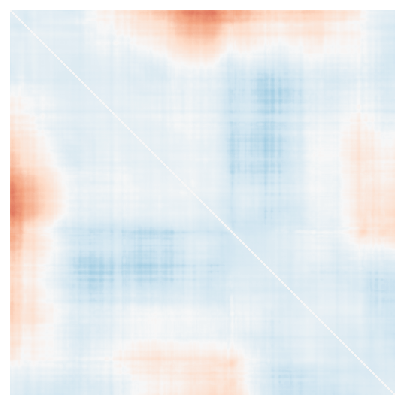

alt


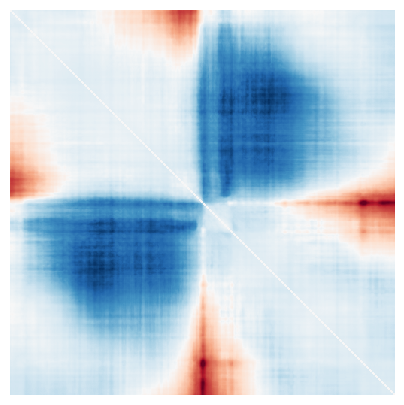

alt-ref


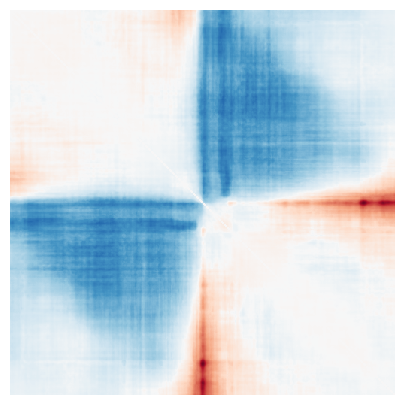

SCD, ref
[29.20304  34.249912 47.26238  50.733376 41.835712 38.592457]
SCD, alt
[ 82.21485  102.59583  102.36704   96.51255   99.303856  81.06004 ]
SCD, alt with ref
[66.40858  81.13919  83.22414  77.6617   78.53029  63.848145]


In [23]:
for exp_index in range(0, num_experiments, 2):
   
    reference_prediction_matrix = preds_stream[exp_index]
    prediction_matrix = preds_stream[exp_index+1]

    ref_maps = ut_dense(reference_prediction_matrix)
    alt_maps = ut_dense(prediction_matrix)

    print("ref")
    plot_map(ref_maps[:,:,0])
    print("alt")
    plot_map(alt_maps[:,:,0])
    print("alt-ref")
    plot_map(alt_maps[:,:,0] - ref_maps[:,:,0])

    print("SCD, ref")
    print(calculate_SCD(ref_maps))
    print("SCD, alt")
    print(calculate_SCD(alt_maps))
    print("SCD, alt with ref")
    print(calculate_SCD(alt_maps, ref_maps))  
    
    # write_stat_metrics_to_h5(prediction_matrix,
    #                             reference_prediction_matrix,
    #                             stats_out,
    #                             int(exp_index/2),
    #                             head_index,
    #                             model_index,
    #                              diagonal_offset=2,
    #                             stat_metrics=stats)  

In [ ]:
for key in stats_out:
    print(key)

In [ ]:
genome_open.close()
stats_out.close()